In [1]:
# ============================================
# 📦 Step 1: Import Libraries
# ============================================

import warnings
warnings.filterwarnings('ignore')
os.environ['OPENCV_LOG_LEVEL'] = 'SILENT'  # Suppress libpng ICC warnings

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import cv2
import random
from tqdm import tqdm
from pathlib import Path
import kagglehub

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# ============================================
# 📁 Step 2: Download and Load Dataset
# ============================================

path = kagglehub.dataset_download("khanfashee/nih-chest-x-ray-14-224x224-resized")
BASE_PATH = Path(path)

df = pd.read_csv(BASE_PATH / "Data_Entry_2017.csv")
images_dir = BASE_PATH / "images-224" / "images-224"
df["Image Path"] = [str(images_dir / p) for p in df["Image Index"].values]

DISEASE_CATEGORIES = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
]

for disease in DISEASE_CATEGORIES:
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)

sample_paths = df['Image Path'].sample(200, random_state=42).values
missing = [p for p in sample_paths if not os.path.exists(p)]
if missing:
    raise FileNotFoundError(f"❌ Missing {len(missing)} images!")

print(f"✅ Loaded {len(df):,} images")

✅ Loaded 112,120 images


In [3]:
BASE_PATH

PosixPath('/root/.cache/kagglehub/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized/versions/3')

In [4]:
# ============================================
# ⚙️ Step 3: Configuration
# ============================================

class Config:
    img_size = 224
    encoder_backbone = 'custom'  # 'custom' or 'mobilenet_v2'
    feat_dim = 256
    proj_dim = 128
    
    batch_size = 32  # Reduced from 64 to avoid OOM
    pretrain_epochs = 40
    finetune_epochs = 60
    lr_pretrain = 1e-3
    lr_finetune = 5e-5
    temperature = 0.1
    
    num_workers = 4
    use_subset = False
    
    # Attention & Segmentation parameters (as per documentation)
    num_regions = 6
    attention_layers = [2, 3, 4]
    
    # Multi-task loss weights (as per documentation)
    alpha_contrastive = 1.0   # Contrastive loss weight
    beta_reconstruction = 0.5  # Reconstruction loss weight
    gamma_segmentation = 0.2   # Segmentation consistency loss weight
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cfg = Config()

# Memory optimization
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

print("⚙️ Configuration:")
print(f"   Device: {cfg.device}")
print(f"   Batch size: {cfg.batch_size}")
print(f"   Encoder backbone: {cfg.encoder_backbone}")
print(f"   Num regions: {cfg.num_regions}")
print(f"   Loss weights: α={cfg.alpha_contrastive}, β={cfg.beta_reconstruction}, γ={cfg.gamma_segmentation}")

if torch.cuda.is_available():
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


⚙️ Configuration:
   Device: cuda
   Batch size: 32
   Num regions: 6
   Loss weights: α=1.0, β=0.5, γ=0.2
   GPU Memory: 85.0 GB


In [5]:
# ============================================
# 💾 Step 3.5: Checkpoint & Resume Configuration
# ============================================

import os
import shutil
from datetime import datetime

OPTION_NAME = "option5"

# ===== RESUME CONFIGURATION =====
CHECKPOINT_DATASET_NAME = "option5-ssl-checkpoints"  # Unique for Option 5
RESUME_SSL_PRETRAINING = True
RESUME_FINETUNING = True
SSL_CHECKPOINT_FILE = "latest"
FINETUNE_CHECKPOINT_FILE = "latest"

IN_KAGGLE = os.path.exists('/kaggle')
IN_COLAB = False

try:
    from google.colab import drive
    drive.mount('/content/drive')
    CHECKPOINT_DIR = '/content/drive/MyDrive/chest_xray_ssl'
    IN_COLAB = True
except:
    pass

if IN_KAGGLE:
    CHECKPOINT_DIR = '/kaggle/working/checkpoints'
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    
    # Load checkpoints from ALL versions of the dataset (v1, v2, v3, etc.)
    # This allows you to keep adding new versions while preserving old checkpoints
    input_path = '/kaggle/input'
    if os.path.exists(input_path):
        found_any = False
        # Find all dataset folders that match our checkpoint dataset name
        for dataset_folder in sorted(os.listdir(input_path)):
            if dataset_folder.startswith(CHECKPOINT_DATASET_NAME):
                dataset_path = os.path.join(input_path, dataset_folder)
                if os.path.isdir(dataset_path):
                    # Check for .pth files in multiple locations:
                    # 1. Directly in dataset folder
                    # 2. In 'checkpoints' subdirectory
                    # 3. In any subdirectory
                    search_paths = [dataset_path]
                    
                    # Add checkpoints subdirectory if it exists
                    checkpoints_subdir = os.path.join(dataset_path, 'checkpoints')
                    if os.path.isdir(checkpoints_subdir):
                        search_paths.append(checkpoints_subdir)
                    
                    # Also check any other subdirectories for .pth files
                    for item in os.listdir(dataset_path):
                        item_path = os.path.join(dataset_path, item)
                        if os.path.isdir(item_path) and item != 'checkpoints':
                            search_paths.append(item_path)
                    
                    for search_path in search_paths:
                        pth_files = [f for f in os.listdir(search_path) if f.endswith('.pth')]
                        if pth_files:
                            found_any = True
                            rel_path = os.path.relpath(search_path, input_path)
                            print(f"📂 Found checkpoints in: {rel_path}")
                            for f in pth_files:
                                src = os.path.join(search_path, f)
                                dst = os.path.join(CHECKPOINT_DIR, f)
                                # Only copy if destination doesn't exist (keep newest)
                                if not os.path.exists(dst):
                                    shutil.copy2(src, dst)
                                    print(f"   📦 Copied: {f}")
                                else:
                                    # Check if source is newer
                                    src_time = os.path.getmtime(src)
                                    dst_time = os.path.getmtime(dst)
                                    if src_time > dst_time:
                                        shutil.copy2(src, dst)
                                        print(f"   🔄 Updated: {f} (newer version)")
        
        if not found_any:
            print(f"ℹ️ No checkpoint datasets found matching: {CHECKPOINT_DATASET_NAME}*")
    
    # List what we have
    existing = [f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.pth')]
    if existing:
        print(f"✅ Total checkpoints available: {len(existing)}")
    else:
        print(f"ℹ️ Starting fresh - no checkpoints loaded")
        
elif not IN_COLAB:
    CHECKPOINT_DIR = './checkpoints'

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def save_checkpoint(state, filename):
    filepath = os.path.join(CHECKPOINT_DIR, filename)
    state['saved_at'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    torch.save(state, filepath)
    print(f"💾 Saved: {filename}")
    if IN_KAGGLE: torch.save(state, f'/kaggle/working/{filename}')

def load_checkpoint(filename):
    filepath = os.path.join(CHECKPOINT_DIR, filename)
    if os.path.exists(filepath):
        checkpoint = torch.load(filepath, map_location=cfg.device, weights_only=False)
        print(f"✅ Loaded: {filename}")
        return checkpoint
    return None

def find_latest_checkpoint(prefix):
    if not os.path.exists(CHECKPOINT_DIR): return None
    latest = f'{prefix}_latest.pth'
    if os.path.exists(os.path.join(CHECKPOINT_DIR, latest)): return latest
    import re
    pattern = re.compile(rf'{prefix}_epoch(\d+)\.pth')
    max_epoch, best = -1, None
    for f in os.listdir(CHECKPOINT_DIR):
        m = pattern.match(f)
        if m and int(m.group(1)) > max_epoch: max_epoch, best = int(m.group(1)), f
    return best

print(f"🔧 Environment: {'Kaggle' if IN_KAGGLE else 'Colab' if IN_COLAB else 'Local'}")
print(f"📂 Checkpoint dir: {CHECKPOINT_DIR}")

🔧 Environment: Local
📂 Checkpoint dir: ./checkpoints


In [6]:
# ============================================
# 🫁 Step 4: Multi-Region Segmentation
# ============================================

def multi_region_segmentation(image):
    """
    Divide image into 6 anatomical regions:
    - Upper-Left, Upper-Right
    - Middle-Left, Middle-Right
    - Lower-Left, Lower-Right
    """
    if len(image.shape) == 3 and image.shape[0] == 1:
        image = image[0]
    
    h, w = image.shape
    regions = {}
    
    h_third = h // 3
    w_half = w // 2
    
    region_names = [
        'upper_left', 'upper_right',
        'middle_left', 'middle_right',
        'lower_left', 'lower_right'
    ]
    
    for i, name in enumerate(region_names):
        regions[name] = np.zeros_like(image)
    
    regions['upper_left'][0:h_third, 0:w_half] = 1
    regions['upper_right'][0:h_third, w_half:w] = 1
    regions['middle_left'][h_third:2*h_third, 0:w_half] = 1
    regions['middle_right'][h_third:2*h_third, w_half:w] = 1
    regions['lower_left'][2*h_third:h, 0:w_half] = 1
    regions['lower_right'][2*h_third:h, w_half:w] = 1
    
    return regions


def visualize_regions(image):
    """Visualize regions with different colors"""
    if len(image.shape) == 3 and image.shape[0] == 1:
        image = image[0]
    
    regions = multi_region_segmentation(image)
    h, w = image.shape
    colored = np.zeros((h, w, 3))
    
    colors = {
        'upper_left': [1, 0, 0],
        'upper_right': [0, 1, 0],
        'middle_left': [0, 0, 1],
        'middle_right': [1, 1, 0],
        'lower_left': [1, 0, 1],
        'lower_right': [0, 1, 1]
    }
    
    for region_name, color in colors.items():
        mask = regions[region_name] > 0.5
        colored[mask] = np.array(color)
    
    return colored

print("✅ Region segmentation functions defined")

✅ Region segmentation functions defined


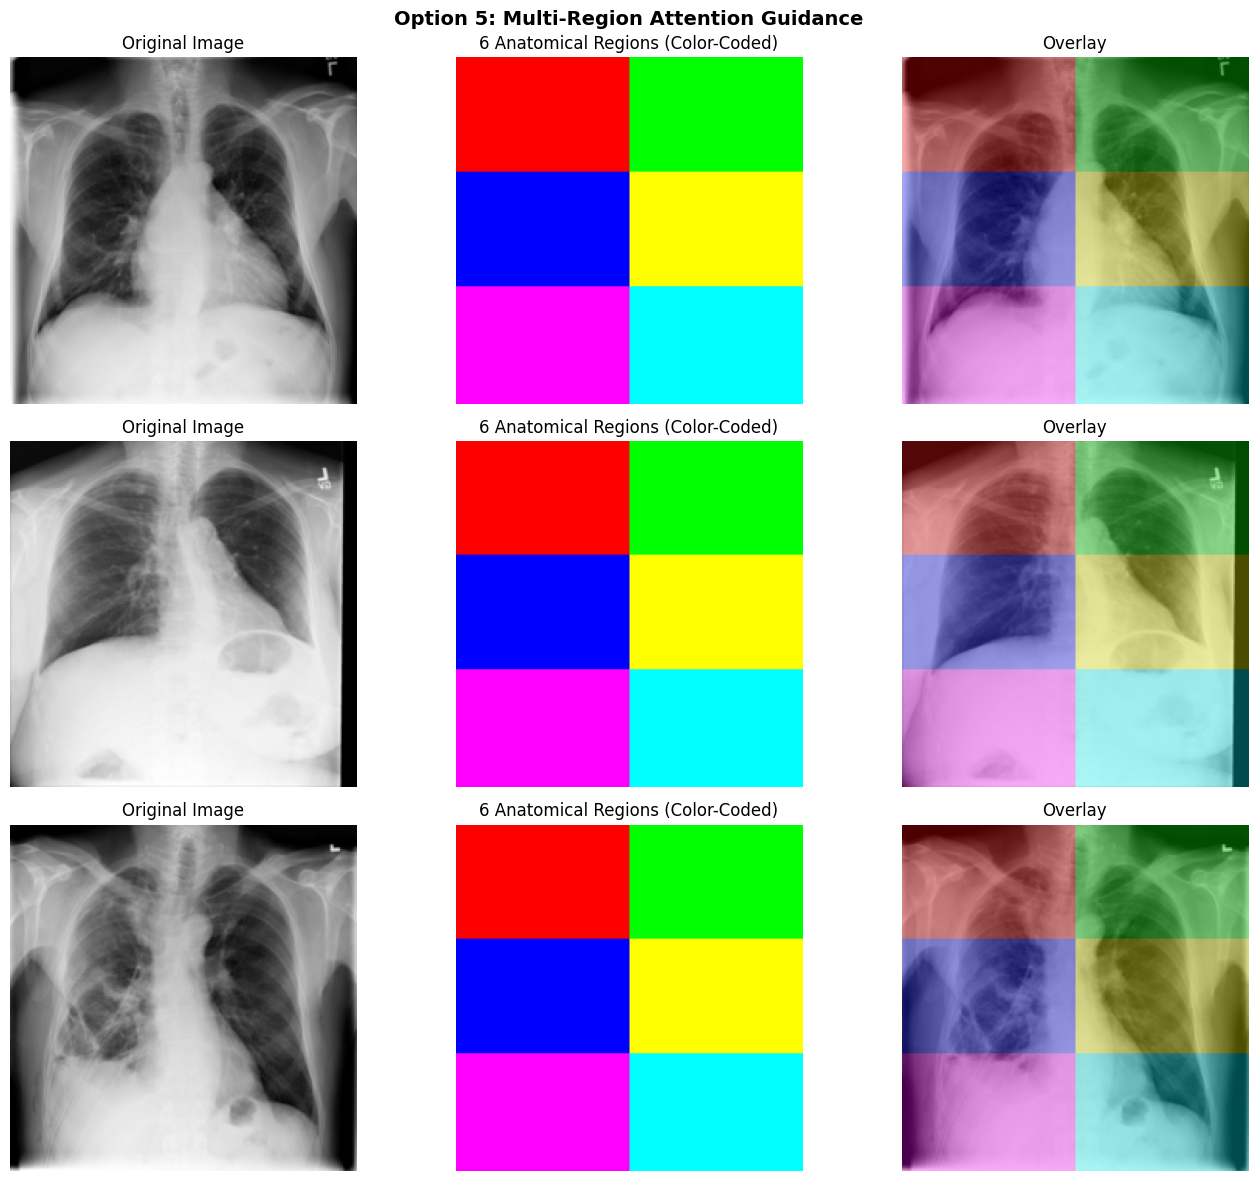

✅ Region visualization complete


In [7]:
# ============================================
# 👁️ Step 5: Visualize Region Segmentation
# ============================================

sample_indices = [0, 100, 500]
fig, axes = plt.subplots(len(sample_indices), 3, figsize=(14, 4*len(sample_indices)))

for i, idx in enumerate(sample_indices):
    img_path = df.iloc[idx]['Image Path']
    img = Image.open(img_path).convert('L')
    img = img.resize((cfg.img_size, cfg.img_size), Image.LANCZOS)
    img_np = np.array(img, dtype=np.float32) / 255.0
    
    axes[i, 0].imshow(img_np, cmap='gray')
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')
    
    # Region masks
    regions = multi_region_segmentation(img_np)
    region_vis = visualize_regions(img_np)
    axes[i, 1].imshow(region_vis)
    axes[i, 1].set_title('6 Anatomical Regions (Color-Coded)')
    axes[i, 1].axis('off')
    
    # Overlay
    overlay = np.stack([img_np, img_np, img_np], axis=2)
    overlay = 0.7 * overlay + 0.3 * region_vis
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title('Overlay')
    axes[i, 2].axis('off')

plt.suptitle('Option 5: Multi-Region Attention Guidance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('option5_region_attention.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Region visualization complete")

In [ ]:
# ============================================
# 🔄 Step 6: Context-Aware Augmentation
# ============================================

def apply_augmentation(image):
    """Standard augmentation"""
    # Rotation
    if random.random() > 0.5:
        angle = random.uniform(-10, 10)
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    
    # Horizontal flip
    # Note: .copy() is needed to avoid negative strides from np.fliplr
    if random.random() > 0.5:
        image = np.fliplr(image).copy()
    
    # Brightness
    if random.random() > 0.5:
        factor = random.uniform(0.8, 1.2)
        image = np.clip(image * factor, 0, 1)
    
    # Contrast
    if random.random() > 0.5:
        mean = image.mean()
        factor = random.uniform(0.8, 1.2)
        image = np.clip((image - mean) * factor + mean, 0, 1)
    
    # Gaussian noise
    if random.random() > 0.6:
        noise = np.random.normal(0, 0.02, image.shape)
        image = np.clip(image + noise, 0, 1)
    
    return image

print("✅ Augmentation function defined")

✅ Augmentation function defined


In [ ]:
# ============================================
# 📦 Step 7: Dataset Classes
# ============================================

class SegmentationGuidedSSLDataset(Dataset):
    """
    SSL dataset for Option 5: Segmentation-Guided Attention
    
    Note: The new SegmentationGuidedEncoder has a built-in SegmentationBranch
    that learns to segment automatically - no external masks needed!
    We still return region_masks for visualization/debugging purposes.
    """
    
    def __init__(self, df, img_size=224):
        self.df = df.copy().reset_index(drop=True)
        self.img_size = img_size
        
        sample_paths = self.df['Image Path'].sample(min(200, len(self.df)), random_state=42).values
        missing = [p for p in sample_paths if not os.path.exists(p)]
        if missing:
            raise FileNotFoundError(f"❌ Missing {len(missing)} images!")
        
        print(f"📦 SegmentationGuidedSSLDataset: {len(self.df)} samples")
        print(f"   (Encoder learns segmentation automatically via SegmentationBranch)")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['Image Path']
        
        img = Image.open(img_path).convert('L')
        img = img.resize((self.img_size, self.img_size), Image.LANCZOS)
        img = np.array(img, dtype=np.float32) / 255.0
        
        # Two augmented views for contrastive learning
        view1 = apply_augmentation(img.copy())
        view2 = apply_augmentation(img.copy())
        
        view1 = torch.tensor(view1[None, ...], dtype=torch.float32)
        view2 = torch.tensor(view2[None, ...], dtype=torch.float32)
        
        # Region masks for visualization/debugging (not used in forward pass)
        regions = multi_region_segmentation(img)
        region_masks = np.stack([regions[k] for k in sorted(regions.keys())], axis=0)
        region_masks = torch.tensor(region_masks, dtype=torch.float32)
        
        return view1, view2, region_masks


# Alias for backward compatibility
AttentionGuidedDataset = SegmentationGuidedSSLDataset


class ClassificationDataset(Dataset):
    """Classification dataset for fine-tuning WITH augmentation support"""
    
    def __init__(self, df, disease_categories, img_size=224, is_training=False):
        self.df = df.copy().reset_index(drop=True)
        self.disease_categories = disease_categories
        self.img_size = img_size
        self.is_training = is_training  # ✅ Augmentation during fine-tuning!
        
        print(f"📦 ClassificationDataset: {len(self.df)} samples (training={is_training})")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img = Image.open(row['Image Path']).convert('L')
        img = img.resize((self.img_size, self.img_size), Image.LANCZOS)
        img = np.array(img, dtype=np.float32) / 255.0
        
        # ✅ Apply augmentation during training (like DannyNet)
        if self.is_training:
            if np.random.random() > 0.5:
                img = np.fliplr(img).copy()
            img = img * (0.8 + 0.4 * np.random.random())
            mean = img.mean()
            img = (img - mean) * (0.8 + 0.4 * np.random.random()) + mean
            if np.random.random() > 0.5:
                angle = np.random.uniform(-10, 10)
                img = rotate(img, angle, reshape=False, mode='constant', cval=0)
            img = np.clip(img, 0, 1)
        
        img = torch.tensor(img[None, ...], dtype=torch.float32)
        labels = torch.tensor([row[d] for d in self.disease_categories], dtype=torch.float32)
        
        return img, labels

print("✅ Dataset classes defined (with training augmentation support)")

✅ Dataset classes defined (with training augmentation support)


In [ ]:
# ============================================
# 🏗️ Step 8: Segmentation-Guided Attention Architecture
# ============================================
# As per documentation: SpatialAttentionModule + SegmentationBranch

def conv_block(in_c, out_c, kernel=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel, stride, padding),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )

def residual_block(channels):
    return nn.Sequential(
        conv_block(channels, channels),
        conv_block(channels, channels)
    )


class SpatialAttentionModule(nn.Module):
    """
    Learns where to focus in the feature map (as per documentation)
    
    Architecture: Conv(C → C/8) → ReLU → Conv(C/8 → 1) → Sigmoid
    Output: Attention map (B, 1, H, W) with values 0-1
    """
    def __init__(self, in_channels):
        super().__init__()
        reduced_channels = max(in_channels // 8, 8)
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, reduced_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        """Returns attention-weighted features and attention map"""
        attention_map = self.attention(x)  # (B, 1, H, W)
        return x * attention_map, attention_map


class SegmentationBranch(nn.Module):
    """
    Lightweight decoder for pseudo-mask generation (as per documentation)
    
    Architecture:
    Conv(256 → 128) → BN → ReLU
    Conv(128 → 64) → BN → ReLU
    Conv(64 → 1) → Sigmoid
    
    Output: Predicted segmentation mask (B, 1, H, W)
    """
    def __init__(self, in_channels=256):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decoder(x)


class SegmentationGuidedEncoder(nn.Module):
    """
    Modified encoder with integrated segmentation (as per documentation)
    
    Pipeline:
    Stage 1: 224×224 → 112×112 (64 channels)
    Stage 2: 112×112 → 56×56 (128 channels)
    Stage 3: 56×56 → 28×28 (256 channels) [Attention + Segmentation Branch]
    Stage 4: 28×28 → 14×14 (512 channels) [Attention]
    Stage 5: 14×14 → 1×1 (512 channels)
    Global Features (feat_dim)
    
    Key Innovation: Segmentation-based Feature Weighting
    weighted_features = features × (1.0 + seg_mask)
    """
    def __init__(self, in_channels=1, feat_dim=256):
        super().__init__()
        
        # Stage 1: 224 → 112
        self.stage1 = nn.Sequential(
            conv_block(in_channels, 64),
            residual_block(64),
            nn.MaxPool2d(2)
        )
        
        # Stage 2: 112 → 56
        self.stage2 = nn.Sequential(
            conv_block(64, 128),
            residual_block(128),
            nn.MaxPool2d(2)
        )
        
        # Stage 3: 56 → 28 (Attention + Segmentation applied here)
        self.stage3 = nn.Sequential(
            conv_block(128, 256),
            residual_block(256),
            residual_block(256),
            nn.MaxPool2d(2)
        )
        self.spatial_attention_3 = SpatialAttentionModule(256)
        self.seg_branch = SegmentationBranch(256)  # Generates pseudo-mask
        
        # Stage 4: 28 → 14 (Attention applied here)
        self.stage4 = nn.Sequential(
            conv_block(256, 512),
            residual_block(512),
            residual_block(512),
            nn.MaxPool2d(2)
        )
        self.spatial_attention_4 = SpatialAttentionModule(512)
        
        # Stage 5: 14 → 1 (Global pooling)
        self.stage5 = nn.Sequential(
            conv_block(512, 512),
            residual_block(512),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # FC layers
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, feat_dim)
        )
    
    def forward(self, x, return_segmentation=False, return_attention=False):
        """
        Forward pass with optional segmentation and attention outputs
        
        Args:
            x: Input image (B, 1, H, W)
            return_segmentation: Return predicted segmentation mask
            return_attention: Return attention maps
        
        Returns:
            features: Global feature vector (B, feat_dim)
            seg_mask: Predicted segmentation (if return_segmentation=True)
            attention_maps: Dict of attention maps (if return_attention=True)
        """
        attention_maps = {}
        
        # Stage 1-2
        x = self.stage1(x)
        x = self.stage2(x)
        
        # Stage 3 with attention and segmentation
        x = self.stage3(x)
        x, attn3 = self.spatial_attention_3(x)
        attention_maps['stage3'] = attn3
        
        # Generate segmentation mask from stage 3 features
        seg_mask = self.seg_branch(x)
        
        # Segmentation-based feature weighting (KEY INNOVATION)
        # Resize seg_mask to match feature map size
        seg_mask_resized = F.interpolate(seg_mask, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = x * (1.0 + seg_mask_resized)  # Amplify segmented regions
        
        # Stage 4 with attention
        x = self.stage4(x)
        x, attn4 = self.spatial_attention_4(x)
        attention_maps['stage4'] = attn4
        
        # Stage 5 and FC
        x = self.stage5(x)
        features = self.fc(x.view(x.size(0), -1))
        
        # Build output
        if return_segmentation and return_attention:
            return features, seg_mask, attention_maps
        elif return_segmentation:
            return features, seg_mask
        elif return_attention:
            return features, attention_maps
        else:
            return features


class ProjectionHead(nn.Module):
    def __init__(self, feat_dim=256, proj_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.BatchNorm1d(feat_dim),
            nn.ReLU(),
            nn.Linear(feat_dim, proj_dim)
        )
    
    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):
    def __init__(self, feat_dim=256, img_size=224):
        super().__init__()
        self.init_size = img_size // 32
        self.fc = nn.Sequential(
            nn.Linear(feat_dim, 256 * self.init_size * self.init_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, 2, 1), nn.Sigmoid()
        )
    
    def forward(self, z):
        x = self.fc(z)
        return self.decoder(x.view(z.size(0), 256, self.init_size, self.init_size))


class Classifier(nn.Module):
    def __init__(self, feat_dim=256, num_classes=14):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)


# Initialize models
encoder = SegmentationGuidedEncoder(feat_dim=cfg.feat_dim).to(cfg.device)
proj_head = ProjectionHead(cfg.feat_dim, cfg.proj_dim).to(cfg.device)
decoder = Decoder(cfg.feat_dim, cfg.img_size).to(cfg.device)

total_params = sum(p.numel() for m in [encoder, proj_head, decoder] for p in m.parameters())
print(f"✅ Segmentation-Guided Encoder initialized ({total_params:,} parameters)")
print(f"   Components: SpatialAttentionModule + SegmentationBranch")
print(f"   Key innovation: weighted_features = features × (1.0 + seg_mask)")

✅ Segmentation-Guided Encoder initialized (25,634,452 parameters)
   Components: SpatialAttentionModule + SegmentationBranch
   Key innovation: weighted_features = features × (1.0 + seg_mask)


In [ ]:
# ============================================
# 🔥 Step 9: Loss Functions (Multi-Task as per documentation)
# ============================================

def nt_xent_loss(z1, z2, temperature=0.1):
    """Standard NT-Xent contrastive loss"""
    device = z1.device
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    batch_size = z1.shape[0]
    representations = torch.cat([z1, z2], dim=0)
    similarity = torch.matmul(representations, representations.T) / temperature
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=device)
    similarity = similarity.masked_fill(mask, -float('inf'))
    labels = torch.cat([torch.arange(batch_size) + batch_size,
                        torch.arange(batch_size)]).to(device)
    return F.cross_entropy(similarity, labels)


def segmentation_consistency_loss(seg_mask_1, seg_mask_2):
    """
    Segmentation Consistency Loss (as per documentation)
    
    Encourages consistent segmentation between two augmented views
    
    Loss = MSE(seg_mask_1, seg_mask_2)
    
    Intuition:
    - Same image → same segmentation
    - Different augmentations → should still identify same lungs
    - Self-supervised: no ground truth needed
    """
    return F.mse_loss(seg_mask_1, seg_mask_2)


def multi_task_loss(proj_1, proj_2, rec_1, rec_2, view_1, view_2, 
                    seg_mask_1, seg_mask_2, temperature=0.1,
                    alpha=1.0, beta=0.5, gamma=0.2):
    """
    Multi-Task Loss (as per documentation)
    
    Total Loss = α × Contrastive Loss 
               + β × Reconstruction Loss 
               + γ × Segmentation Consistency Loss
    
    Args:
        proj_1, proj_2: Projected features for contrastive learning
        rec_1, rec_2: Reconstructed images
        view_1, view_2: Original input views
        seg_mask_1, seg_mask_2: Predicted segmentation masks
        alpha: Contrastive loss weight (default: 1.0)
        beta: Reconstruction loss weight (default: 0.5)
        gamma: Segmentation consistency weight (default: 0.2)
    
    Returns:
        total_loss, contrastive_loss, reconstruction_loss, segmentation_loss
    """
    # Contrastive loss
    cont_loss = nt_xent_loss(proj_1, proj_2, temperature)
    
    # Reconstruction loss
    recon_loss = (F.mse_loss(rec_1, view_1) + F.mse_loss(rec_2, view_2)) / 2
    
    # Segmentation consistency loss
    seg_loss = segmentation_consistency_loss(seg_mask_1, seg_mask_2)
    
    # Multi-task total
    total_loss = alpha * cont_loss + beta * recon_loss + gamma * seg_loss
    
    return total_loss, cont_loss, recon_loss, seg_loss


class FocalLoss(nn.Module):
    """
    ⭐ Focal Loss for handling class imbalance (from DannyNet SOTA)
    FL(p_t) = -alpha * (1 - p_t)^gamma * log(p_t)
    """
    def __init__(self, alpha=1.0, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()


print("✅ Loss functions defined")
print("   📐 Multi-task loss: α×Contrastive + β×Reconstruction + γ×SegConsistency")
print(f"   Weights: α={cfg.alpha_contrastive}, β={cfg.beta_reconstruction}, γ={cfg.gamma_segmentation}")
print("   ⭐ FocalLoss: For class imbalance (α=1.0, γ=2.0)")

✅ Loss functions defined
   📐 Multi-task loss: α×Contrastive + β×Reconstruction + γ×SegConsistency
   Weights: α=1.0, β=0.5, γ=0.2
   ⭐ FocalLoss: For class imbalance (α=1.0, γ=2.0)


In [ ]:
# ============================================
# 📊 Step 10: Create Data Loaders (Patient-Level Split)
# ============================================

# ⚠️ CRITICAL: Patient-level splitting to prevent data leakage
print("="*60)
print("🔀 PATIENT-LEVEL SPLITTING")
print("="*60)

unique_patients = df['Patient ID'].unique()
print(f"Total unique patients: {len(unique_patients):,}")

# Split patients: 93% train, 5% val, 2% test
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.02, random_state=42
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.052, random_state=42
)

train_df = df[df['Patient ID'].isin(train_patients)].copy()
val_df = df[df['Patient ID'].isin(val_patients)].copy()
test_df = df[df['Patient ID'].isin(test_patients)].copy()

print(f"✓ Train: {len(train_df):,} images from {len(train_patients):,} patients")
print(f"✓ Val: {len(val_df):,} images from {len(val_patients):,} patients")
print(f"✓ Test: {len(test_df):,} images from {len(test_patients):,} patients")
print("="*60)

if cfg.use_subset:
    train_df = train_df.head(cfg.subset_size)
    val_df = val_df.head(cfg.subset_size // 4)
    test_df = test_df.head(cfg.subset_size // 8)
    print(f"⚡ Using subset: {len(train_df)} train, {len(val_df)} val, {len(test_df)} test")

# Datasets - NOW WITH AUGMENTATION FOR TRAINING
train_pretrain_ds = AttentionGuidedDataset(train_df, img_size=cfg.img_size)
train_class_ds = ClassificationDataset(train_df, DISEASE_CATEGORIES, cfg.img_size, is_training=True)  # ✅ Augmentation ON
val_class_ds = ClassificationDataset(val_df, DISEASE_CATEGORIES, cfg.img_size, is_training=False)
test_class_ds = ClassificationDataset(test_df, DISEASE_CATEGORIES, cfg.img_size, is_training=False)

# DataLoaders - FAST PIPELINE (like tf.data)
# 🚀 num_workers: Parallel data loading (like num_parallel_calls)
# 🚀 pin_memory: Faster CPU→GPU transfer  
# 🚀 prefetch_factor: Prefetch batches per worker (like prefetch)
# 🚀 persistent_workers: Keep workers alive between epochs
pretrain_loader = DataLoader(
    train_pretrain_ds, batch_size=cfg.batch_size, shuffle=True,
    num_workers=cfg.num_workers, pin_memory=True, drop_last=True,
    prefetch_factor=2, persistent_workers=True if cfg.num_workers > 0 else False
)
train_loader = DataLoader(
    train_class_ds, batch_size=cfg.batch_size, shuffle=True,
    num_workers=cfg.num_workers, pin_memory=True, drop_last=True,
    prefetch_factor=2, persistent_workers=True if cfg.num_workers > 0 else False
)
val_loader = DataLoader(
    val_class_ds, batch_size=cfg.batch_size, shuffle=False,
    num_workers=cfg.num_workers, pin_memory=True,
    prefetch_factor=2, persistent_workers=True if cfg.num_workers > 0 else False
)
test_loader = DataLoader(
    test_class_ds, batch_size=cfg.batch_size, shuffle=False,
    num_workers=cfg.num_workers, pin_memory=True,
    prefetch_factor=2, persistent_workers=True if cfg.num_workers > 0 else False
)

print(f"✅ DataLoaders ready - FAST PIPELINE (with training augmentation)")
print(f"   Train batches: {len(pretrain_loader)}")
print(f"   Test batches: {len(test_loader)}")

🔀 PATIENT-LEVEL SPLITTING
Total unique patients: 30,805
✓ Train: 103,847 images from 28,618 patients
✓ Val: 5,974 images from 1,570 patients
✓ Test: 2,299 images from 617 patients
📦 SegmentationGuidedSSLDataset: 103847 samples
   (Encoder learns segmentation automatically via SegmentationBranch)
📦 ClassificationDataset: 103847 samples (training=True)
📦 ClassificationDataset: 5974 samples (training=False)
📦 ClassificationDataset: 2299 samples (training=False)
✅ DataLoaders ready - FAST PIPELINE (with training augmentation)
   Train batches: 3245
   Test batches: 72


In [ ]:
# ============================================
# 🚀 Step 11: Segmentation-Guided SSL Pretraining (Multi-Task)
# ============================================

# Clear GPU cache before training
if torch.cuda.is_available():
    torch.cuda.empty_cache()

optimizer_ssl = torch.optim.Adam(
    list(encoder.parameters()) + list(proj_head.parameters()) + list(decoder.parameters()),
    lr=cfg.lr_pretrain, weight_decay=1e-4
)

ssl_history = {'loss': [], 'contrastive': [], 'reconstruction': [], 'segmentation': []}
START_EPOCH = 1

if RESUME_SSL_PRETRAINING:
    ckpt_file = find_latest_checkpoint(f'{OPTION_NAME}_ssl') if SSL_CHECKPOINT_FILE == "latest" else SSL_CHECKPOINT_FILE
    if ckpt_file:
        checkpoint = load_checkpoint(ckpt_file)
        if checkpoint:
            encoder.load_state_dict(checkpoint['encoder'])
            proj_head.load_state_dict(checkpoint['proj_head'])
            decoder.load_state_dict(checkpoint['decoder'])
            if 'optimizer' in checkpoint: optimizer_ssl.load_state_dict(checkpoint['optimizer'])
            ssl_history = checkpoint.get('ssl_history', ssl_history)
            START_EPOCH = checkpoint['epoch'] + 1
            print(f"🔄 Resuming from epoch {START_EPOCH}")
    else:
        print("⚠️ No checkpoint found. Starting fresh.")

if START_EPOCH > cfg.pretrain_epochs:
    print(f"✅ SSL Pretraining already complete")
else:
    print(f"\n🧠 Starting Option 5: Segmentation-Guided SSL Pretraining")
    print(f"   Multi-task loss: α×Contrastive + β×Reconstruction + γ×SegConsistency")
    print(f"   Epochs: {START_EPOCH} → {cfg.pretrain_epochs}")
    print("=" * 60)
    
    for epoch in range(START_EPOCH, cfg.pretrain_epochs + 1):
        encoder.train()
        proj_head.train()
        decoder.train()
        
        total_loss = total_cont = total_recon = total_seg = 0
        
        loader = tqdm(pretrain_loader, desc=f"Epoch {epoch}/{cfg.pretrain_epochs}") if not IN_KAGGLE else pretrain_loader
        for view1, view2, region_masks in loader:
            view1 = view1.to(cfg.device)
            view2 = view2.to(cfg.device)
            
            optimizer_ssl.zero_grad()
            
            z1, seg_mask1 = encoder(view1, return_segmentation=True)
            z2, seg_mask2 = encoder(view2, return_segmentation=True)
            
            p1, p2 = proj_head(z1), proj_head(z2)
            rec1, rec2 = decoder(z1), decoder(z2)
            
            loss, cont_loss, recon_loss, seg_loss = multi_task_loss(
                p1, p2, rec1, rec2, view1, view2, seg_mask1, seg_mask2,
                temperature=cfg.temperature,
                alpha=cfg.alpha_contrastive,
                beta=cfg.beta_reconstruction,
                gamma=cfg.gamma_segmentation
            )
            
            loss.backward()
            optimizer_ssl.step()
            
            total_loss += loss.item()
            total_cont += cont_loss.item()
            total_recon += recon_loss.item()
            total_seg += seg_loss.item()
            if not IN_KAGGLE:
                loader.set_postfix({'loss': f'{loss.item():.4f}', 'seg': f'{seg_loss.item():.4f}'})
            
            # Free memory
            del z1, z2, p1, p2, rec1, rec2, seg_mask1, seg_mask2, loss, cont_loss, recon_loss, seg_loss
        
        # Clear cache at end of epoch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        n = len(pretrain_loader)
        ssl_history['loss'].append(total_loss / n)
        ssl_history['contrastive'].append(total_cont / n)
        ssl_history['reconstruction'].append(total_recon / n)
        ssl_history['segmentation'].append(total_seg / n)
        
        print(f"Epoch {epoch}: Loss={total_loss/n:.4f}, Cont={total_cont/n:.4f}, "
              f"Recon={total_recon/n:.4f}, Seg={total_seg/n:.4f}")
        
        save_checkpoint({
            'epoch': epoch, 'encoder': encoder.state_dict(),
            'proj_head': proj_head.state_dict(), 'decoder': decoder.state_dict(),
            'optimizer': optimizer_ssl.state_dict(), 'ssl_history': ssl_history,
        }, f'{OPTION_NAME}_ssl_latest.pth')
        save_checkpoint({
            'epoch': epoch, 'encoder': encoder.state_dict(),
            'proj_head': proj_head.state_dict(), 'decoder': decoder.state_dict(),
            'ssl_history': ssl_history,
        }, f'{OPTION_NAME}_ssl_epoch{epoch}.pth')
    
    print("\n✅ Segmentation-Guided SSL Pretraining Complete!")

✅ Loaded: option5_ssl_latest.pth
🔄 Resuming from epoch 26
✅ SSL Pretraining already complete


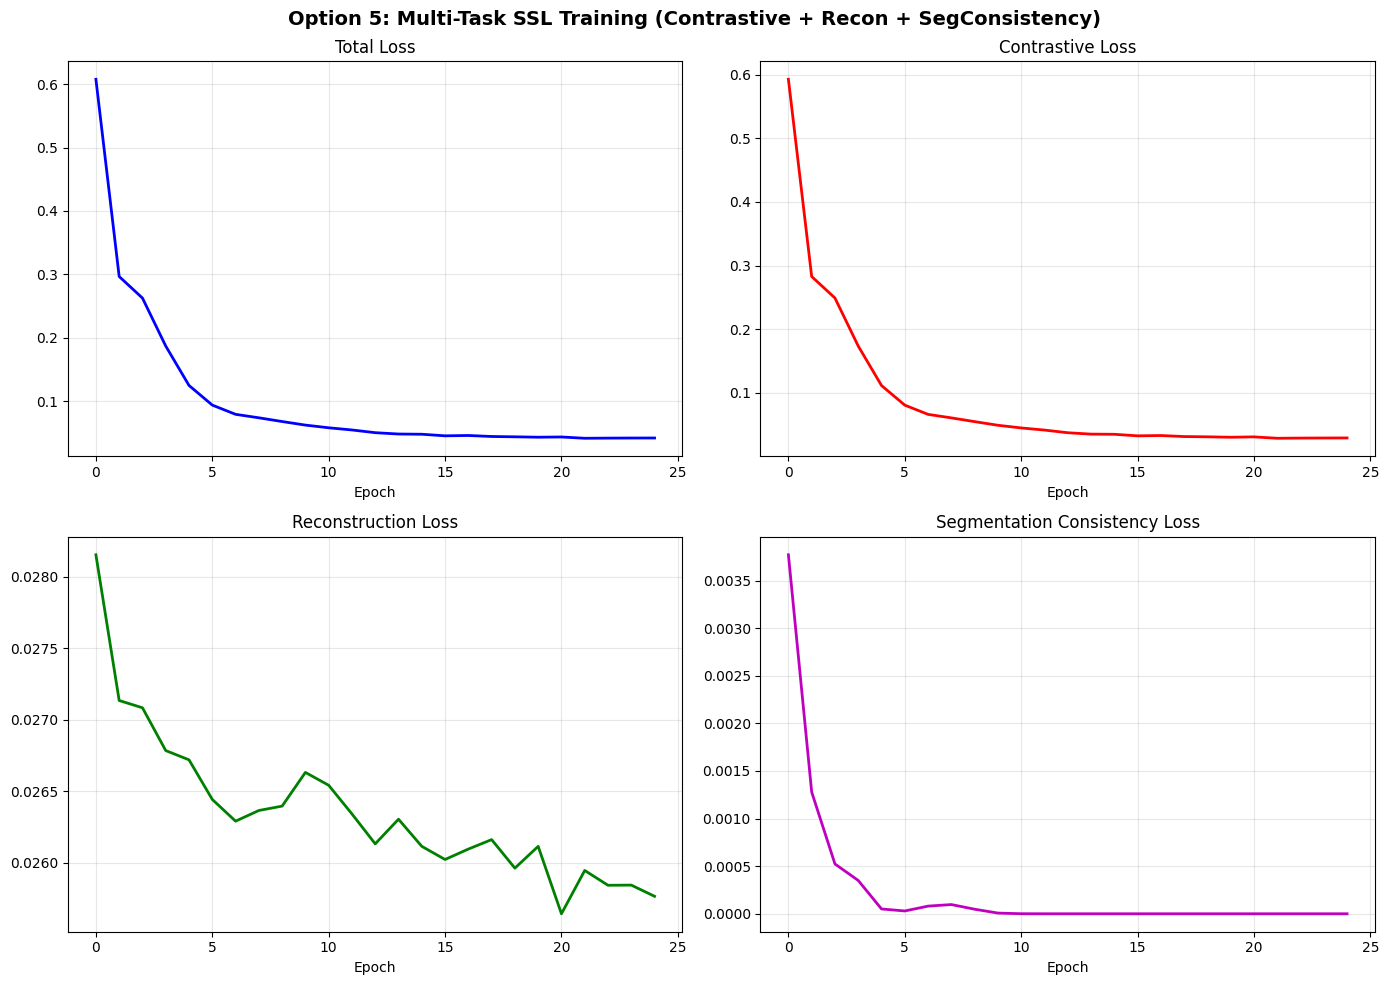

💾 Pretrained model saved: option5_ssl_pretrained.pth


In [ ]:
# ============================================
# 📈 Step 12: Plot SSL Curves & Save Model
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(ssl_history['loss'], 'b-', linewidth=2)
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(ssl_history['contrastive'], 'r-', linewidth=2)
axes[0, 1].set_title('Contrastive Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(ssl_history['reconstruction'], 'g-', linewidth=2)
axes[1, 0].set_title('Reconstruction Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(ssl_history.get('segmentation', []), 'm-', linewidth=2)
axes[1, 1].set_title('Segmentation Consistency Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Option 5: Multi-Task SSL Training (Contrastive + Recon + SegConsistency)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('option5_ssl_curves.png', dpi=150, bbox_inches='tight')
plt.show()

torch.save({
    'encoder': encoder.state_dict(),
    'proj_head': proj_head.state_dict(),
    'decoder': decoder.state_dict(),
}, 'option5_ssl_pretrained.pth')

print("💾 Pretrained model saved: option5_ssl_pretrained.pth")

In [ ]:
# ============================================
# 🎯 Step 13-15: Fine-tuning, Evaluation, & Summary
# ============================================
# KEY IMPROVEMENTS (inspired by DannyNet SOTA):
# 1. UNFREEZE encoder with differential learning rate
# 2. Use Focal Loss instead of BCE
# 3. Use AdamW optimizer
# 4. More aggressive LR scheduler (factor=0.1, patience=2)
# ============================================

# ✅ UNFREEZE encoder for fine-tuning (CRITICAL for performance!)
for param in encoder.parameters():
    param.requires_grad = True  # UNFROZEN!
encoder.train()

classifier = Classifier(cfg.feat_dim, len(DISEASE_CATEGORIES)).to(cfg.device)

# ✅ Use Focal Loss
criterion = FocalLoss(alpha=1.0, gamma=2.0)

# ✅ Differential learning rates with AdamW
encoder_lr = cfg.lr_finetune / 10
classifier_lr = cfg.lr_finetune

optimizer_ft = torch.optim.AdamW([
    {'params': encoder.parameters(), 'lr': encoder_lr},
    {'params': classifier.parameters(), 'lr': classifier_lr}
], weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_ft, mode='max', patience=2, factor=0.1, min_lr=1e-7
)

print("🔧 Fine-tuning Configuration:")
print(f"   ✅ Encoder: UNFROZEN with LR={encoder_lr:.2e}")
print(f"   ✅ Classifier LR: {classifier_lr:.2e}")
print(f"   ✅ Loss: FocalLoss (α=1.0, γ=2.0)")
print(f"   ✅ Optimizer: AdamW")

finetune_history = {'train_loss': [], 'train_auc': [], 'val_loss': [], 'val_auc': []}
best_val_auc = 0
FINETUNE_START_EPOCH = 1

if RESUME_FINETUNING:
    ckpt_file = find_latest_checkpoint(f'{OPTION_NAME}_finetune') if FINETUNE_CHECKPOINT_FILE == "latest" else FINETUNE_CHECKPOINT_FILE
    if ckpt_file:
        checkpoint = load_checkpoint(ckpt_file)
        if checkpoint:
            classifier.load_state_dict(checkpoint['classifier'])
            if 'encoder' in checkpoint:
                encoder.load_state_dict(checkpoint['encoder'])
            if 'optimizer' in checkpoint:
                try:
                    optimizer_ft.load_state_dict(checkpoint['optimizer'])
                except:
                    print("⚠️ Optimizer state incompatible, starting fresh")
            if 'scheduler' in checkpoint:
                try:
                    scheduler.load_state_dict(checkpoint['scheduler'])
                except:
                    pass
            finetune_history = checkpoint.get('finetune_history', finetune_history)
            best_val_auc = checkpoint.get('best_val_auc', 0)
            FINETUNE_START_EPOCH = checkpoint['epoch'] + 1
            print(f"🔄 Resuming fine-tuning from epoch {FINETUNE_START_EPOCH}")
    else:
        print("⚠️ No checkpoint found. Starting fresh.")

if FINETUNE_START_EPOCH > cfg.finetune_epochs:
    print(f"✅ Fine-tuning already complete")
else:
    print(f"\n🎯 Starting Fine-tuning (ENCODER UNFROZEN)")
    print(f"   Epochs: {FINETUNE_START_EPOCH} → {cfg.finetune_epochs}")
    print("=" * 50)
    
    for epoch in range(FINETUNE_START_EPOCH, cfg.finetune_epochs + 1):
        encoder.train()  # Encoder is also training now!
        classifier.train()
        train_loss = 0
        train_preds, train_targets = [], []
        
        loader = tqdm(train_loader, desc=f"Train {epoch}/{cfg.finetune_epochs}") if not IN_KAGGLE else train_loader
        for images, targets in loader:
            images, targets = images.to(cfg.device), targets.to(cfg.device)
            optimizer_ft.zero_grad()
            
            # ✅ NO torch.no_grad() - encoder is being fine-tuned!
            features = encoder(images)
            logits = classifier(features)
            loss = criterion(logits, targets)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)
            optimizer_ft.step()
            
            train_loss += loss.item()
            train_preds.append(torch.sigmoid(logits).detach().cpu())
            train_targets.append(targets.cpu())
        
        encoder.eval()
        classifier.eval()
        val_loss = 0
        val_preds, val_targets = [], []
        
        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(cfg.device), targets.to(cfg.device)
                features = encoder(images)
                logits = classifier(features)
                val_loss += criterion(logits, targets).item()
                val_preds.append(torch.sigmoid(logits).cpu())
                val_targets.append(targets.cpu())
        
        train_preds = torch.cat(train_preds).numpy()
        train_targets = torch.cat(train_targets).numpy()
        val_preds = torch.cat(val_preds).numpy()
        val_targets = torch.cat(val_targets).numpy()
        
        train_auc = np.mean([roc_auc_score(train_targets[:, i], train_preds[:, i]) 
                             for i in range(len(DISEASE_CATEGORIES)) 
                             if len(np.unique(train_targets[:, i])) > 1])
        val_auc = np.mean([roc_auc_score(val_targets[:, i], val_preds[:, i]) 
                           for i in range(len(DISEASE_CATEGORIES)) 
                           if len(np.unique(val_targets[:, i])) > 1])
        
        finetune_history['train_loss'].append(train_loss / len(train_loader))
        finetune_history['train_auc'].append(train_auc)
        finetune_history['val_loss'].append(val_loss / len(val_loader))
        finetune_history['val_auc'].append(val_auc)
        scheduler.step(val_auc)
        
        current_lr = optimizer_ft.param_groups[0]['lr']
        print(f"Epoch {epoch}: Train AUC={train_auc:.4f}, Val AUC={val_auc:.4f}, LR={current_lr:.2e}")
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            save_checkpoint({'encoder': encoder.state_dict(), 'classifier': classifier.state_dict(),
                            'val_auc': val_auc, 'epoch': epoch}, f'{OPTION_NAME}_best_model.pth')
            print(f"  ✅ Best model saved! Val AUC: {val_auc:.4f}")
        
        save_checkpoint({
            'epoch': epoch, 'encoder': encoder.state_dict(),
            'classifier': classifier.state_dict(),
            'optimizer': optimizer_ft.state_dict(), 'scheduler': scheduler.state_dict(),
            'finetune_history': finetune_history, 'best_val_auc': best_val_auc,
        }, f'{OPTION_NAME}_finetune_latest.pth')
        save_checkpoint({
            'epoch': epoch, 'encoder': encoder.state_dict(),
            'classifier': classifier.state_dict(),
            'finetune_history': finetune_history, 'best_val_auc': best_val_auc,
        }, f'{OPTION_NAME}_finetune_epoch{epoch}.pth')
    
    print(f"\n🏆 Best Validation AUC: {best_val_auc:.4f}")

🔧 Fine-tuning Configuration:
   ✅ Encoder: UNFROZEN with LR=5.00e-06
   ✅ Classifier LR: 5.00e-05
   ✅ Loss: FocalLoss (α=1.0, γ=2.0)
   ✅ Optimizer: AdamW
⚠️ No checkpoint found. Starting fresh.

🎯 Starting Fine-tuning (ENCODER UNFROZEN)
   Epochs: 1 → 60


Train 1/60: 100%|██████████| 3245/3245 [18:49<00:00,  2.87it/s]


Epoch 1: Train AUC=0.5849, Val AUC=0.6400, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.6400
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch1.pth


Train 2/60: 100%|██████████| 3245/3245 [18:49<00:00,  2.87it/s]


Epoch 2: Train AUC=0.6409, Val AUC=0.6735, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.6735
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch2.pth


Train 3/60: 100%|██████████| 3245/3245 [18:45<00:00,  2.88it/s]


Epoch 3: Train AUC=0.6601, Val AUC=0.6871, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.6871
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch3.pth


Train 4/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 4: Train AUC=0.6685, Val AUC=0.6928, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.6928
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch4.pth


Train 5/60: 100%|██████████| 3245/3245 [18:44<00:00,  2.89it/s]


Epoch 5: Train AUC=0.6798, Val AUC=0.6986, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.6986
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch5.pth


Train 6/60: 100%|██████████| 3245/3245 [18:37<00:00,  2.90it/s]


Epoch 6: Train AUC=0.6862, Val AUC=0.7035, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7035
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch6.pth


Train 7/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 7: Train AUC=0.6908, Val AUC=0.7085, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7085
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch7.pth


Train 8/60: 100%|██████████| 3245/3245 [18:44<00:00,  2.89it/s]


Epoch 8: Train AUC=0.6955, Val AUC=0.7100, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7100
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch8.pth


Train 9/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 9: Train AUC=0.6982, Val AUC=0.7132, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7132
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch9.pth


Train 10/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 10: Train AUC=0.7000, Val AUC=0.7180, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7180
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch10.pth


Train 11/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 11: Train AUC=0.7026, Val AUC=0.7151, LR=5.00e-06
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch11.pth


Train 12/60: 100%|██████████| 3245/3245 [18:47<00:00,  2.88it/s]


Epoch 12: Train AUC=0.7062, Val AUC=0.7203, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7203
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch12.pth


Train 13/60: 100%|██████████| 3245/3245 [18:45<00:00,  2.88it/s]


Epoch 13: Train AUC=0.7106, Val AUC=0.7265, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7265
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch13.pth


Train 14/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 14: Train AUC=0.7084, Val AUC=0.7256, LR=5.00e-06
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch14.pth


Train 15/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 15: Train AUC=0.7159, Val AUC=0.7277, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7277
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch15.pth


Train 16/60: 100%|██████████| 3245/3245 [18:44<00:00,  2.89it/s]


Epoch 16: Train AUC=0.7150, Val AUC=0.7303, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7303
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch16.pth


Train 17/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 17: Train AUC=0.7174, Val AUC=0.7308, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7308
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch17.pth


Train 18/60: 100%|██████████| 3245/3245 [18:28<00:00,  2.93it/s]


Epoch 18: Train AUC=0.7205, Val AUC=0.7332, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7332
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch18.pth


Train 19/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 19: Train AUC=0.7215, Val AUC=0.7359, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7359
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch19.pth


Train 20/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 20: Train AUC=0.7232, Val AUC=0.7356, LR=5.00e-06
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch20.pth


Train 21/60: 100%|██████████| 3245/3245 [18:45<00:00,  2.88it/s]


Epoch 21: Train AUC=0.7237, Val AUC=0.7411, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7411
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch21.pth


Train 22/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 22: Train AUC=0.7266, Val AUC=0.7443, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7443
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch22.pth


Train 23/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 23: Train AUC=0.7287, Val AUC=0.7447, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7447
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch23.pth


Train 24/60: 100%|██████████| 3245/3245 [18:44<00:00,  2.88it/s]


Epoch 24: Train AUC=0.7286, Val AUC=0.7374, LR=5.00e-06
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch24.pth


Train 25/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 25: Train AUC=0.7310, Val AUC=0.7463, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7463
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch25.pth


Train 26/60: 100%|██████████| 3245/3245 [18:44<00:00,  2.89it/s]


Epoch 26: Train AUC=0.7346, Val AUC=0.7505, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7505
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch26.pth


Train 27/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 27: Train AUC=0.7362, Val AUC=0.7481, LR=5.00e-06
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch27.pth


Train 28/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 28: Train AUC=0.7372, Val AUC=0.7524, LR=5.00e-06
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7524
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch28.pth


Train 29/60: 100%|██████████| 3245/3245 [18:44<00:00,  2.89it/s]


Epoch 29: Train AUC=0.7390, Val AUC=0.7477, LR=5.00e-06
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch29.pth


Train 30/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 30: Train AUC=0.7403, Val AUC=0.7509, LR=5.00e-06
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch30.pth


Train 31/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 31: Train AUC=0.7408, Val AUC=0.7459, LR=5.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch31.pth


Train 32/60: 100%|██████████| 3245/3245 [18:44<00:00,  2.89it/s]


Epoch 32: Train AUC=0.7442, Val AUC=0.7547, LR=5.00e-07
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7547
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch32.pth


Train 33/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 33: Train AUC=0.7438, Val AUC=0.7566, LR=5.00e-07
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7566
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch33.pth


Train 34/60: 100%|██████████| 3245/3245 [18:45<00:00,  2.88it/s]


Epoch 34: Train AUC=0.7452, Val AUC=0.7555, LR=5.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch34.pth


Train 35/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 35: Train AUC=0.7445, Val AUC=0.7554, LR=5.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch35.pth


Train 36/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 36: Train AUC=0.7470, Val AUC=0.7563, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch36.pth


Train 37/60: 100%|██████████| 3245/3245 [18:44<00:00,  2.88it/s]


Epoch 37: Train AUC=0.7456, Val AUC=0.7544, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch37.pth


Train 38/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 38: Train AUC=0.7457, Val AUC=0.7560, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch38.pth


Train 39/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 39: Train AUC=0.7471, Val AUC=0.7564, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch39.pth


Train 40/60: 100%|██████████| 3245/3245 [18:45<00:00,  2.88it/s]


Epoch 40: Train AUC=0.7466, Val AUC=0.7559, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch40.pth


Train 41/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 41: Train AUC=0.7452, Val AUC=0.7563, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch41.pth


Train 42/60: 100%|██████████| 3245/3245 [18:45<00:00,  2.88it/s]


Epoch 42: Train AUC=0.7463, Val AUC=0.7560, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch42.pth


Train 43/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 43: Train AUC=0.7447, Val AUC=0.7553, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch43.pth


Train 44/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 44: Train AUC=0.7439, Val AUC=0.7561, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch44.pth


Train 45/60: 100%|██████████| 3245/3245 [18:45<00:00,  2.88it/s]


Epoch 45: Train AUC=0.7456, Val AUC=0.7555, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch45.pth


Train 46/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 46: Train AUC=0.7474, Val AUC=0.7565, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch46.pth


Train 47/60: 100%|██████████| 3245/3245 [18:46<00:00,  2.88it/s]


Epoch 47: Train AUC=0.7456, Val AUC=0.7562, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch47.pth


Train 48/60: 100%|██████████| 3245/3245 [20:13<00:00,  2.67it/s]


Epoch 48: Train AUC=0.7472, Val AUC=0.7560, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch48.pth


Train 49/60: 100%|██████████| 3245/3245 [20:47<00:00,  2.60it/s]


Epoch 49: Train AUC=0.7452, Val AUC=0.7557, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch49.pth


Train 50/60: 100%|██████████| 3245/3245 [20:48<00:00,  2.60it/s]


Epoch 50: Train AUC=0.7467, Val AUC=0.7571, LR=1.00e-07
💾 Saved: option5_best_model.pth
  ✅ Best model saved! Val AUC: 0.7571
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch50.pth


Train 51/60: 100%|██████████| 3245/3245 [20:49<00:00,  2.60it/s]


Epoch 51: Train AUC=0.7457, Val AUC=0.7566, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch51.pth


Train 52/60: 100%|██████████| 3245/3245 [20:49<00:00,  2.60it/s]


Epoch 52: Train AUC=0.7468, Val AUC=0.7561, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch52.pth


Train 53/60: 100%|██████████| 3245/3245 [20:50<00:00,  2.60it/s]


Epoch 53: Train AUC=0.7458, Val AUC=0.7563, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch53.pth


Train 54/60: 100%|██████████| 3245/3245 [20:50<00:00,  2.60it/s]


Epoch 54: Train AUC=0.7472, Val AUC=0.7549, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch54.pth


Train 55/60: 100%|██████████| 3245/3245 [20:50<00:00,  2.60it/s]


Epoch 55: Train AUC=0.7464, Val AUC=0.7560, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch55.pth


Train 56/60: 100%|██████████| 3245/3245 [20:50<00:00,  2.60it/s]


Epoch 56: Train AUC=0.7470, Val AUC=0.7558, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch56.pth


Train 57/60: 100%|██████████| 3245/3245 [20:49<00:00,  2.60it/s]


Epoch 57: Train AUC=0.7468, Val AUC=0.7565, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch57.pth


Train 58/60: 100%|██████████| 3245/3245 [20:51<00:00,  2.59it/s]


Epoch 58: Train AUC=0.7443, Val AUC=0.7567, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch58.pth


Train 59/60: 100%|██████████| 3245/3245 [20:50<00:00,  2.60it/s]


Epoch 59: Train AUC=0.7463, Val AUC=0.7551, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch59.pth


Train 60/60: 100%|██████████| 3245/3245 [20:55<00:00,  2.58it/s]


Epoch 60: Train AUC=0.7457, Val AUC=0.7561, LR=1.00e-07
💾 Saved: option5_finetune_latest.pth
💾 Saved: option5_finetune_epoch60.pth

🏆 Best Validation AUC: 0.7571


Evaluating Val: 100%|██████████| 187/187 [00:39<00:00,  4.68it/s]



📊 Validation Set - Per-Disease AUC Scores:
Atelectasis         : 0.7609
Cardiomegaly        : 0.7971
Effusion            : 0.8091
Infiltration        : 0.6820
Mass                : 0.7449
Nodule              : 0.6263
Pneumonia           : 0.6800
Pneumothorax        : 0.8061
Consolidation       : 0.7799
Edema               : 0.8409
Emphysema           : 0.8280
Fibrosis            : 0.7424
Pleural_Thickening  : 0.7389
Hernia              : 0.7636

Val Mean AUC        : 0.7571

🎯 OPTIMAL THRESHOLD SEARCH (per-disease)
Atelectasis         : optimal thresh = 0.34, F1 = 0.3174
Cardiomegaly        : optimal thresh = 0.28, F1 = 0.2379
Effusion            : optimal thresh = 0.38, F1 = 0.4189
Infiltration        : optimal thresh = 0.36, F1 = 0.4061
Mass                : optimal thresh = 0.30, F1 = 0.2102
Nodule              : optimal thresh = 0.28, F1 = 0.1428
Pneumonia           : optimal thresh = 0.24, F1 = 0.0494
Pneumothorax        : optimal thresh = 0.34, F1 = 0.2486
Consolidation       : 

Evaluating Test: 100%|██████████| 72/72 [00:19<00:00,  3.60it/s]



📊 Test Set - Per-Disease AUC Scores:
Atelectasis         : 0.7406
Cardiomegaly        : 0.8425
Effusion            : 0.8476
Infiltration        : 0.6501
Mass                : 0.7697
Nodule              : 0.6300
Pneumonia           : 0.6296
Pneumothorax        : 0.8145
Consolidation       : 0.7481
Edema               : 0.8312
Emphysema           : 0.8453
Fibrosis            : 0.7562
Pleural_Thickening  : 0.7119
Hernia              : 0.9298

Test Mean AUC       : 0.7677

📊 Test Set - With Optimal Thresholds:
Disease                   AUC   Thresh       F1  Precision   Recall
------------------------------------------------------------
Atelectasis            0.7406     0.34   0.3041     0.2097   0.5531
Cardiomegaly           0.8425     0.28   0.3699     0.3103   0.4576
Effusion               0.8476     0.38   0.4983     0.4115   0.6313
Infiltration           0.6501     0.36   0.3575     0.2560   0.5924
Mass                   0.7697     0.30   0.2331     0.1592   0.4348
Nodule            

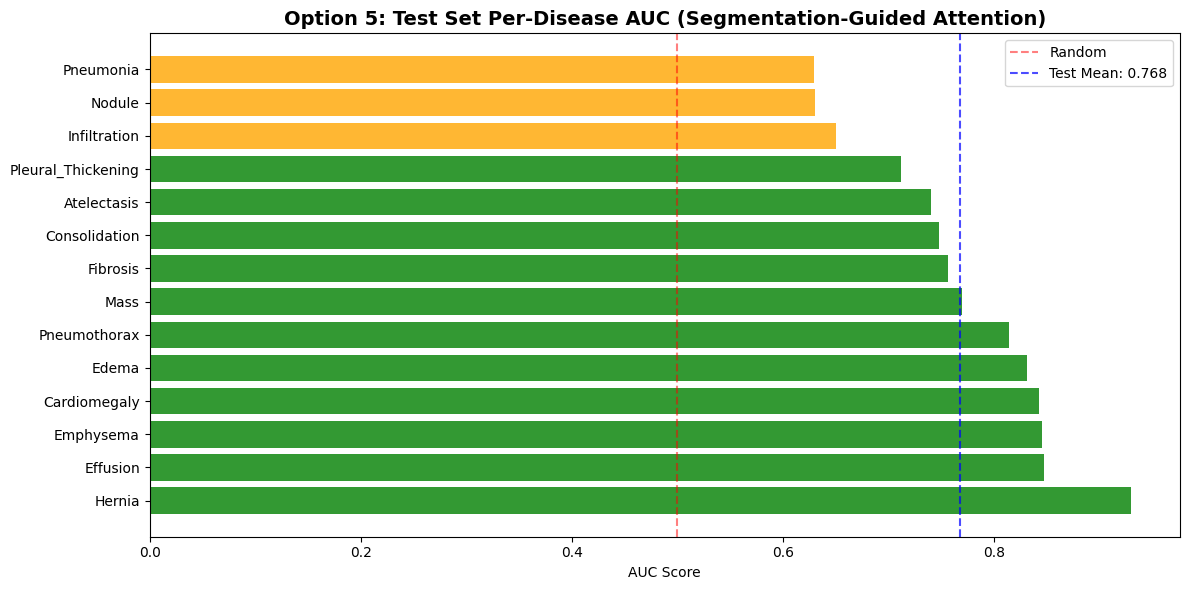


🧠 OPTION 5: SEGMENTATION-GUIDED ATTENTION SUMMARY
Architecture Components (as per documentation):
  📐 SpatialAttentionModule: Conv(C→C/8)→ReLU→Conv(C/8→1)→Sigmoid
  🫁 SegmentationBranch: Lightweight decoder for pseudo-mask generation
  🔗 Feature Weighting: weighted_features = features × (1.0 + seg_mask)

Multi-Task Loss:
  Total = α×Contrastive + β×Reconstruction + γ×SegConsistency
  Weights: α=1.0, β=0.5, γ=0.2

Key Advantages:
  ✅ End-to-end learnable segmentation
  ✅ No ground truth masks needed (self-supervised)
  ✅ Segmentation consistency between augmented views
  ✅ Spatial attention guides feature extraction
  ✅ Interpretable attention maps available

Dataset: NIH Chest X-ray 14 (Patient-Level Split)
  - Training: 103,847 images (28,618 patients)
  - Validation: 5,974 images (1,570 patients)
  - Test: 2,299 images (617 patients)

Results:
  📈 Validation Mean AUC: 0.7571
  🧪 Test Mean AUC: 0.7677


In [ ]:
# ============================================
# 📊 Step 16: Final Evaluation & Test Set
# ============================================

from sklearn.metrics import f1_score, precision_score, recall_score

best_model_path = os.path.join(CHECKPOINT_DIR, f'{OPTION_NAME}_best_model.pth')
checkpoint = torch.load(best_model_path)encoder.load_state_dict(checkpoint['encoder'])
classifier.load_state_dict(checkpoint['classifier'])
encoder.eval()
classifier.eval()

# Validation Set
all_preds, all_targets = [], []
with torch.no_grad():
    loader = tqdm(val_loader, desc="Evaluating Val") if not IN_KAGGLE else val_loader
    for images, targets in loader:
        images = images.to(cfg.device)
        features = encoder(images)
        logits = classifier(features)
        all_preds.append(torch.sigmoid(logits).cpu())
        all_targets.append(targets)

all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

print("\n📊 Validation Set - Per-Disease AUC Scores:")
print("=" * 40)
val_auc_scores = []
for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(all_targets[:, i])) > 1:
        auc = roc_auc_score(all_targets[:, i], all_preds[:, i])
        val_auc_scores.append((disease, auc))
        print(f"{disease:20s}: {auc:.4f}")

val_mean_auc = np.mean([a for _, a in val_auc_scores])
print(f"\n{'Val Mean AUC':20s}: {val_mean_auc:.4f}")

# ============================================
# 🎯 Find Optimal Per-Disease Thresholds
# ============================================
print("\n" + "="*60)
print("🎯 OPTIMAL THRESHOLD SEARCH (per-disease)")
print("="*60)

optimal_thresholds = {}
for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(all_targets[:, i])) > 1:
        best_f1, best_thresh = 0, 0.5
        for thresh in np.arange(0.1, 0.9, 0.02):
            preds_binary = (all_preds[:, i] > thresh).astype(int)
            if preds_binary.sum() > 0 and (1 - preds_binary).sum() > 0:
                f1 = f1_score(all_targets[:, i], preds_binary, zero_division=0)
                if f1 > best_f1:
                    best_f1, best_thresh = f1, thresh
        optimal_thresholds[disease] = best_thresh
        print(f"{disease:20s}: optimal thresh = {best_thresh:.2f}, F1 = {best_f1:.4f}")

# ============================================
# 🧪 Test Set Evaluation (Held-Out)
# ============================================

print("\n" + "="*60)
print("🧪 TEST SET EVALUATION (Patient-Level Held-Out)")
print("="*60)

test_preds, test_targets = [], []
with torch.no_grad():
    loader = tqdm(test_loader, desc="Evaluating Test") if not IN_KAGGLE else test_loader
    for images, targets in loader:
        images = images.to(cfg.device)
        features = encoder(images)
        logits = classifier(features)
        test_preds.append(torch.sigmoid(logits).cpu())
        test_targets.append(targets)

test_preds = torch.cat(test_preds).numpy()
test_targets = torch.cat(test_targets).numpy()

print("\n📊 Test Set - Per-Disease AUC Scores:")
print("=" * 40)
test_auc_scores = []
for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(test_targets[:, i])) > 1:
        auc = roc_auc_score(test_targets[:, i], test_preds[:, i])
        test_auc_scores.append((disease, auc))
        print(f"{disease:20s}: {auc:.4f}")

test_mean_auc = np.mean([a for _, a in test_auc_scores])
print(f"\n{'Test Mean AUC':20s}: {test_mean_auc:.4f}")

# Test with OPTIMAL thresholds
print("\n📊 Test Set - With Optimal Thresholds:")
print("=" * 60)
print(f"{'Disease':20s} {'AUC':>8s} {'Thresh':>8s} {'F1':>8s} {'Precision':>10s} {'Recall':>8s}")
print("-" * 60)

test_f1_scores = []
for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(test_targets[:, i])) > 1:
        auc = roc_auc_score(test_targets[:, i], test_preds[:, i])
        thresh = optimal_thresholds.get(disease, 0.5)
        preds_binary = (test_preds[:, i] > thresh).astype(int)
        f1 = f1_score(test_targets[:, i], preds_binary, zero_division=0)
        prec = precision_score(test_targets[:, i], preds_binary, zero_division=0)
        rec = recall_score(test_targets[:, i], preds_binary, zero_division=0)
        test_f1_scores.append(f1)
        print(f"{disease:20s} {auc:8.4f} {thresh:8.2f} {f1:8.4f} {prec:10.4f} {rec:8.4f}")

print("-" * 60)
print(f"{'MEAN':20s} {test_mean_auc:8.4f} {'--':>8s} {np.mean(test_f1_scores):8.4f}")

# Plot
test_auc_scores.sort(key=lambda x: x[1], reverse=True)
diseases, aucs = zip(*test_auc_scores)

plt.figure(figsize=(12, 6))
colors = ['green' if a >= 0.7 else 'orange' if a >= 0.6 else 'red' for a in aucs]
plt.barh(diseases, aucs, color=colors, alpha=0.8)
plt.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Random')
plt.axvline(test_mean_auc, color='blue', linestyle='--', alpha=0.7, label=f'Test Mean: {test_mean_auc:.3f}')
plt.xlabel('AUC Score')
plt.title('Option 5: Test Set Per-Disease AUC (Segmentation-Guided Attention)', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig(f'{OPTION_NAME}_test_auc_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 70)
print("🧠 OPTION 5: SEGMENTATION-GUIDED ATTENTION SUMMARY")
print("=" * 70)
print(f"Architecture Components (as per documentation):")
print(f"  📐 SpatialAttentionModule: Conv(C→C/8)→ReLU→Conv(C/8→1)→Sigmoid")
print(f"  🫁 SegmentationBranch: Lightweight decoder for pseudo-mask generation")
print(f"  🔗 Feature Weighting: weighted_features = features × (1.0 + seg_mask)")
print(f"\nMulti-Task Loss:")
print(f"  Total = α×Contrastive + β×Reconstruction + γ×SegConsistency")
print(f"  Weights: α={cfg.alpha_contrastive}, β={cfg.beta_reconstruction}, γ={cfg.gamma_segmentation}")
print(f"\nKey Advantages:")
print(f"  ✅ End-to-end learnable segmentation")
print(f"  ✅ No ground truth masks needed (self-supervised)")
print(f"  ✅ Segmentation consistency between augmented views")
print(f"  ✅ Spatial attention guides feature extraction")
print(f"  ✅ Interpretable attention maps available")
print(f"\nDataset: NIH Chest X-ray 14 (Patient-Level Split)")
print(f"  - Training: {len(train_df):,} images ({len(train_patients):,} patients)")
print(f"  - Validation: {len(val_df):,} images ({len(val_patients):,} patients)")
print(f"  - Test: {len(test_df):,} images ({len(test_patients):,} patients)")
print(f"\nResults:")
print(f"  📈 Validation Mean AUC: {val_mean_auc:.4f}")
print(f"  🧪 Test Mean AUC: {test_mean_auc:.4f}")
print("=" * 70)

In [ ]:
# # ============================================
# # 📊 Confusion Matrices (Per Disease)
# # ============================================

# from sklearn.metrics import confusion_matrix

# for i, disease in enumerate(DISEASE_CATEGORIES):
#     if len(np.unique(test_targets[:, i])) > 1:
#         thresh = optimal_thresholds.get(disease, 0.5)
#         preds_binary = (test_preds[:, i] > thresh).astype(int)

#         cm = confusion_matrix(test_targets[:, i], preds_binary)

#         plt.figure(figsize=(4, 3))
#         plt.imshow(cm)
#         plt.title(f'Confusion Matrix: {disease}')
#         plt.xlabel('Predicted')
#         plt.ylabel('Ground Truth')
#         plt.xticks([0,1], ['Neg','Pos'])
#         plt.yticks([0,1], ['Neg','Pos'])

#         for x in range(2):
#             for y in range(2):
#                 plt.text(y, x, cm[x, y], ha='center', va='center')

#         plt.tight_layout()
#         plt.show()


In [ ]:
# # ============================================
# # 📈 ROC Curves (Test Set)
# # ============================================

# from sklearn.metrics import roc_curve, auc

# plt.figure(figsize=(10, 7))

# for i, disease in enumerate(DISEASE_CATEGORIES):
#     if len(np.unique(test_targets[:, i])) > 1:
#         fpr, tpr, _ = roc_curve(test_targets[:, i], test_preds[:, i])
#         roc_auc = auc(fpr, tpr)
#         plt.plot(fpr, tpr, label=f'{disease} (AUC={roc_auc:.2f})')

# plt.plot([0,1], [0,1], linestyle='--', alpha=0.4)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curves – Test Set (Option 5)')
# plt.legend(fontsize=8)
# plt.tight_layout()
# plt.show()


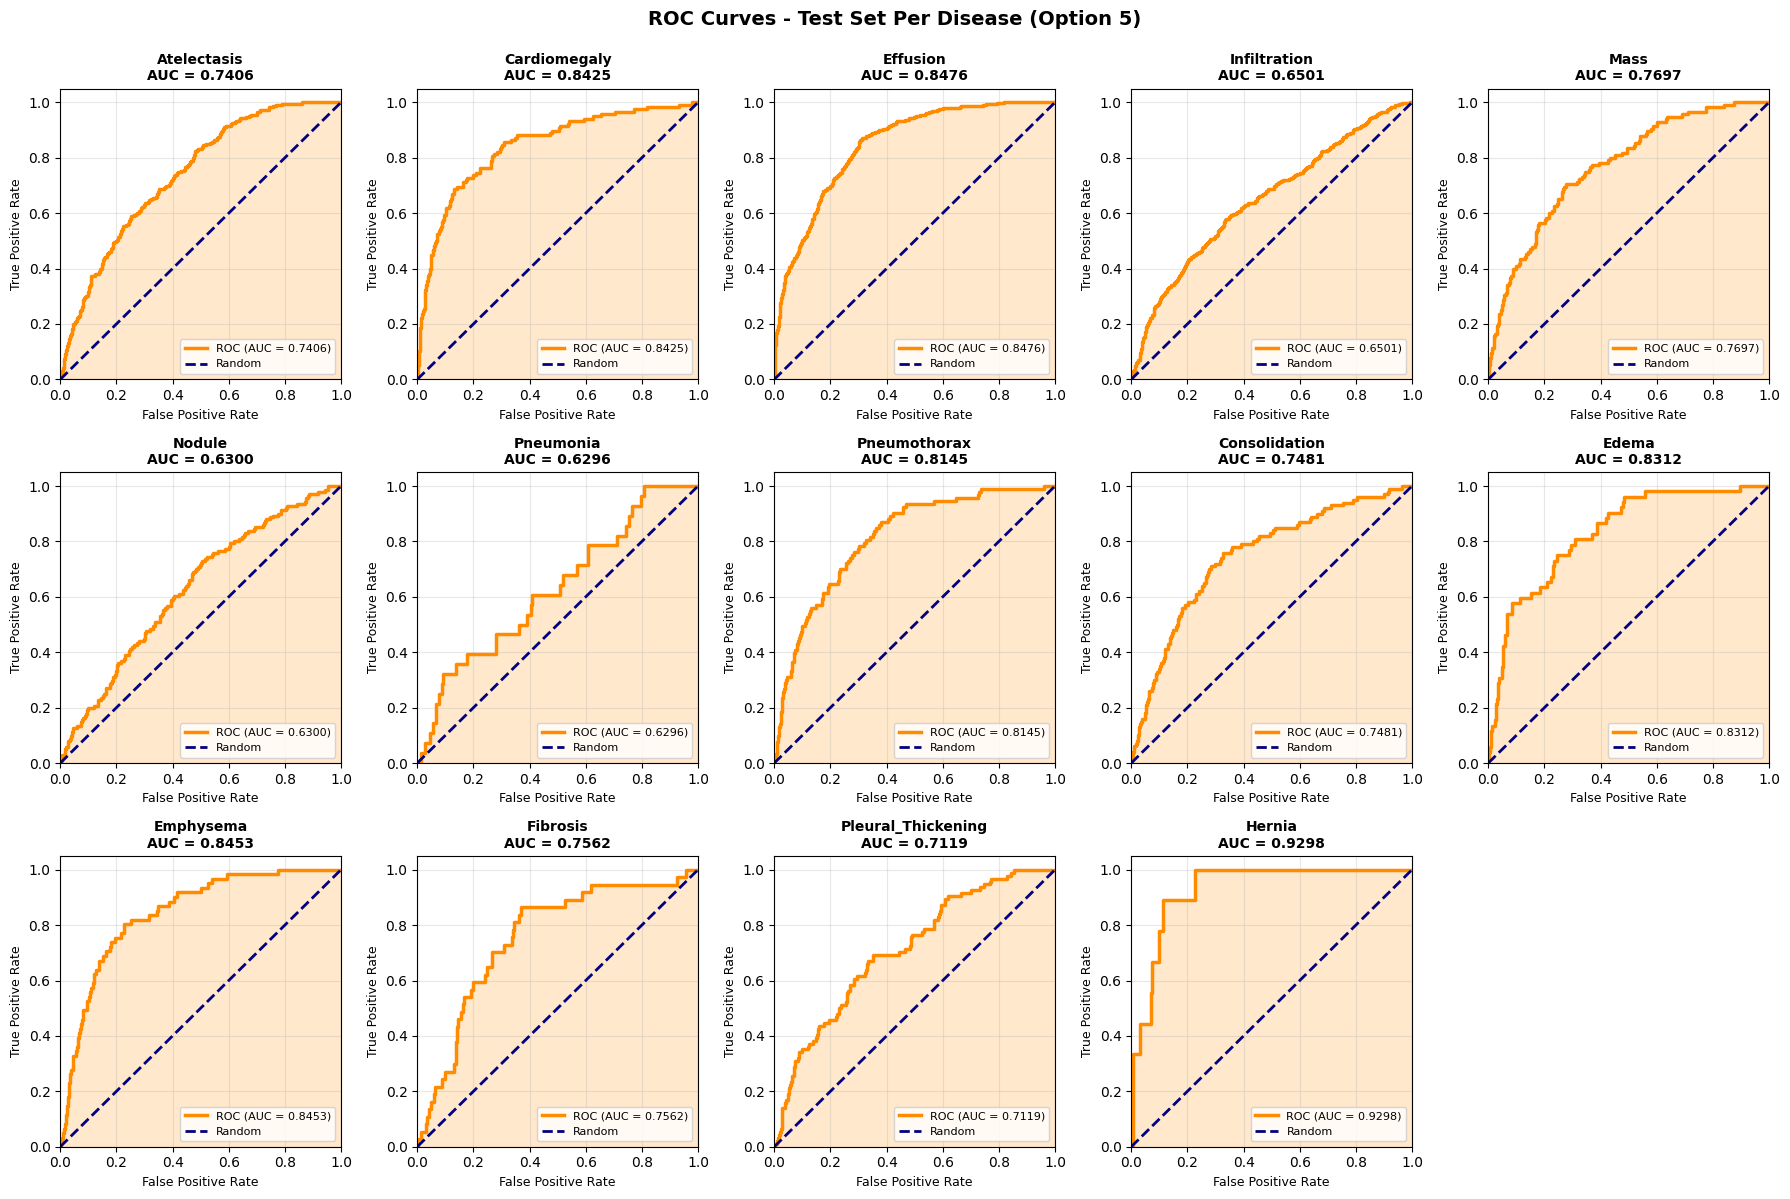

✅ Per-disease ROC curves saved!


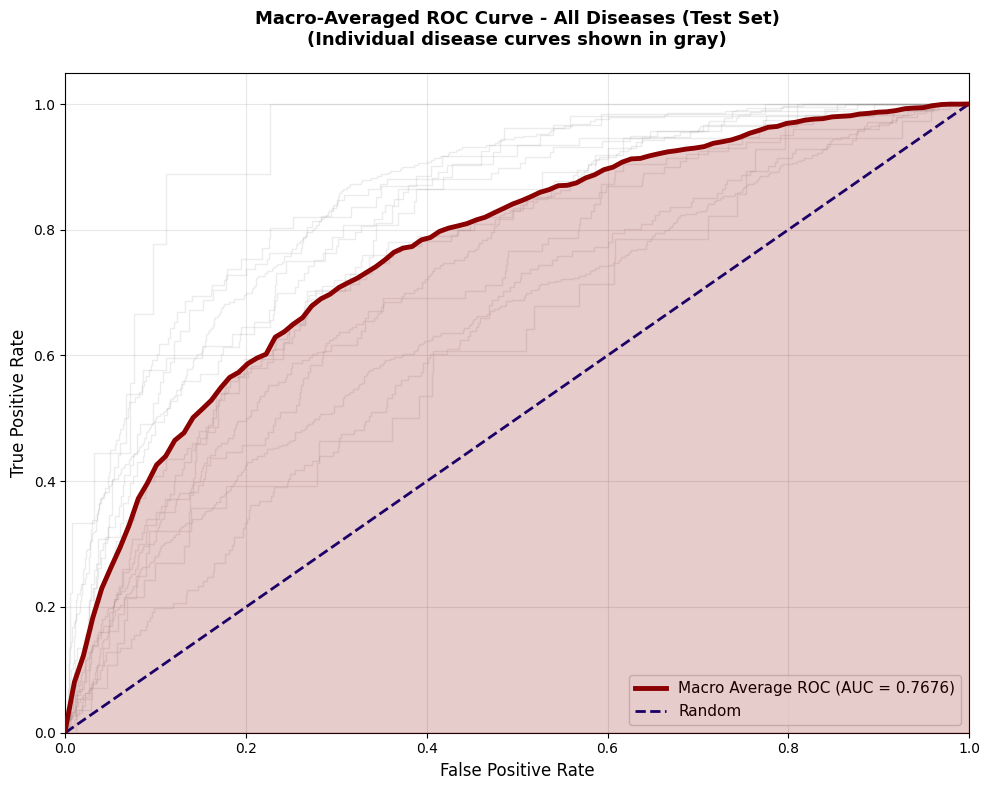

✅ Macro ROC curve saved!

Macro-Averaged ROC AUC: 0.7676

📊 PER-DISEASE ROC AUC STATISTICS
Disease                     AUC     TPR@FPR=0.1    TPR@FPR=0.05
------------------------------------------------------------
Atelectasis              0.7406          0.3053          0.1991
Cardiomegaly             0.8425          0.5932          0.4492
Effusion                 0.8476          0.5015          0.3923
Infiltration             0.6501          0.2810          0.1696
Mass                     0.7697          0.4087          0.2696
Nodule                   0.6300          0.1986          0.1277
Pneumonia                0.6296          0.3214          0.1071
Pneumothorax             0.8145          0.4946          0.3118
Consolidation            0.7481          0.3300          0.1700
Edema                    0.8312          0.5769          0.3462
Emphysema                0.8453          0.5246          0.3279
Fibrosis                 0.7562          0.2703          0.1622
Pleural_Thickeni

In [ ]:
# ============================================
# 📈 Step 18: ROC Curves Visualization
# ============================================

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ============================================
# 📊 Individual ROC Curves Per Disease (3x5 grid)
# ============================================

n_diseases = len(DISEASE_CATEGORIES)
n_cols = 5
n_rows = (n_diseases + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
axes = axes.flatten()

for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(test_targets[:, i])) > 1:
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(test_targets[:, i], test_preds[:, i])
        roc_auc = auc(fpr, tpr)
        
        # Plot
        axes[i].plot(fpr, tpr, color='darkorange', lw=2.5, 
                    label=f'ROC (AUC = {roc_auc:.4f})')
        axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        axes[i].fill_between(fpr, tpr, alpha=0.2, color='darkorange')
        
        axes[i].set_xlim([0.0, 1.0])
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlabel('False Positive Rate', fontsize=9)
        axes[i].set_ylabel('True Positive Rate', fontsize=9)
        axes[i].set_title(f'{disease}\nAUC = {roc_auc:.4f}', fontweight='bold', fontsize=10)
        axes[i].legend(loc="lower right", fontsize=8)
        axes[i].grid(True, alpha=0.3)
    else:
        axes[i].text(0.5, 0.5, f'{disease}\n(Insufficient data)', 
                    ha='center', va='center', transform=axes[i].transAxes, fontsize=10)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('ROC Curves - Test Set Per Disease (Option 5)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'{OPTION_NAME}_roc_curves_per_disease.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Per-disease ROC curves saved!")

# ============================================
# 📊 Macro ROC Curve (Aggregated)
# ============================================

# For macro ROC, we'll compute one-vs-rest for each disease and average
fpr_list, tpr_list, auc_list = [], [], []

for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(test_targets[:, i])) > 1:
        fpr, tpr, _ = roc_curve(test_targets[:, i], test_preds[:, i])
        roc_auc = auc(fpr, tpr)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc_list.append(roc_auc)

# Plot individual curves + macro average
fig, ax = plt.subplots(figsize=(10, 8))

# Plot individual disease curves (faint)
for i, (fpr, tpr, disease_auc) in enumerate(zip(fpr_list, tpr_list, auc_list)):
    ax.plot(fpr, tpr, alpha=0.15, color='gray', linewidth=1)

# Compute and plot macro average
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)

for fpr, tpr in zip(fpr_list, tpr_list):
    mean_tpr += np.interp(mean_fpr, fpr, tpr)

mean_tpr /= len(fpr_list)
macro_auc = auc(mean_fpr, mean_tpr)

ax.plot(mean_fpr, mean_tpr, color='darkred', lw=3.5, 
       label=f'Macro Average ROC (AUC = {macro_auc:.4f})', zorder=10)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random', zorder=5)
ax.fill_between(mean_fpr, mean_tpr, alpha=0.2, color='darkred', zorder=9)

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('Macro-Averaged ROC Curve - All Diseases (Test Set)\n(Individual disease curves shown in gray)', 
            fontsize=13, fontweight='bold', pad=20)
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OPTION_NAME}_roc_curve_macro.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Macro ROC curve saved!")
print(f"\nMacro-Averaged ROC AUC: {macro_auc:.4f}")

# ============================================
# 📋 Detailed ROC Statistics Table
# ============================================

print("\n" + "="*60)
print("📊 PER-DISEASE ROC AUC STATISTICS")
print("="*60)
print(f"{'Disease':20s} {'AUC':>10s} {'TPR@FPR=0.1':>15s} {'TPR@FPR=0.05':>15s}")
print("-"*60)

for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(test_targets[:, i])) > 1:
        fpr, tpr, _ = roc_curve(test_targets[:, i], test_preds[:, i])
        roc_auc = auc(fpr, tpr)
        
        # Find TPR at specific FPR values
        tpr_at_01 = np.interp(0.1, fpr, tpr)
        tpr_at_005 = np.interp(0.05, fpr, tpr)
        
        print(f"{disease:20s} {roc_auc:10.4f} {tpr_at_01:15.4f} {tpr_at_005:15.4f}")

print("="*60)

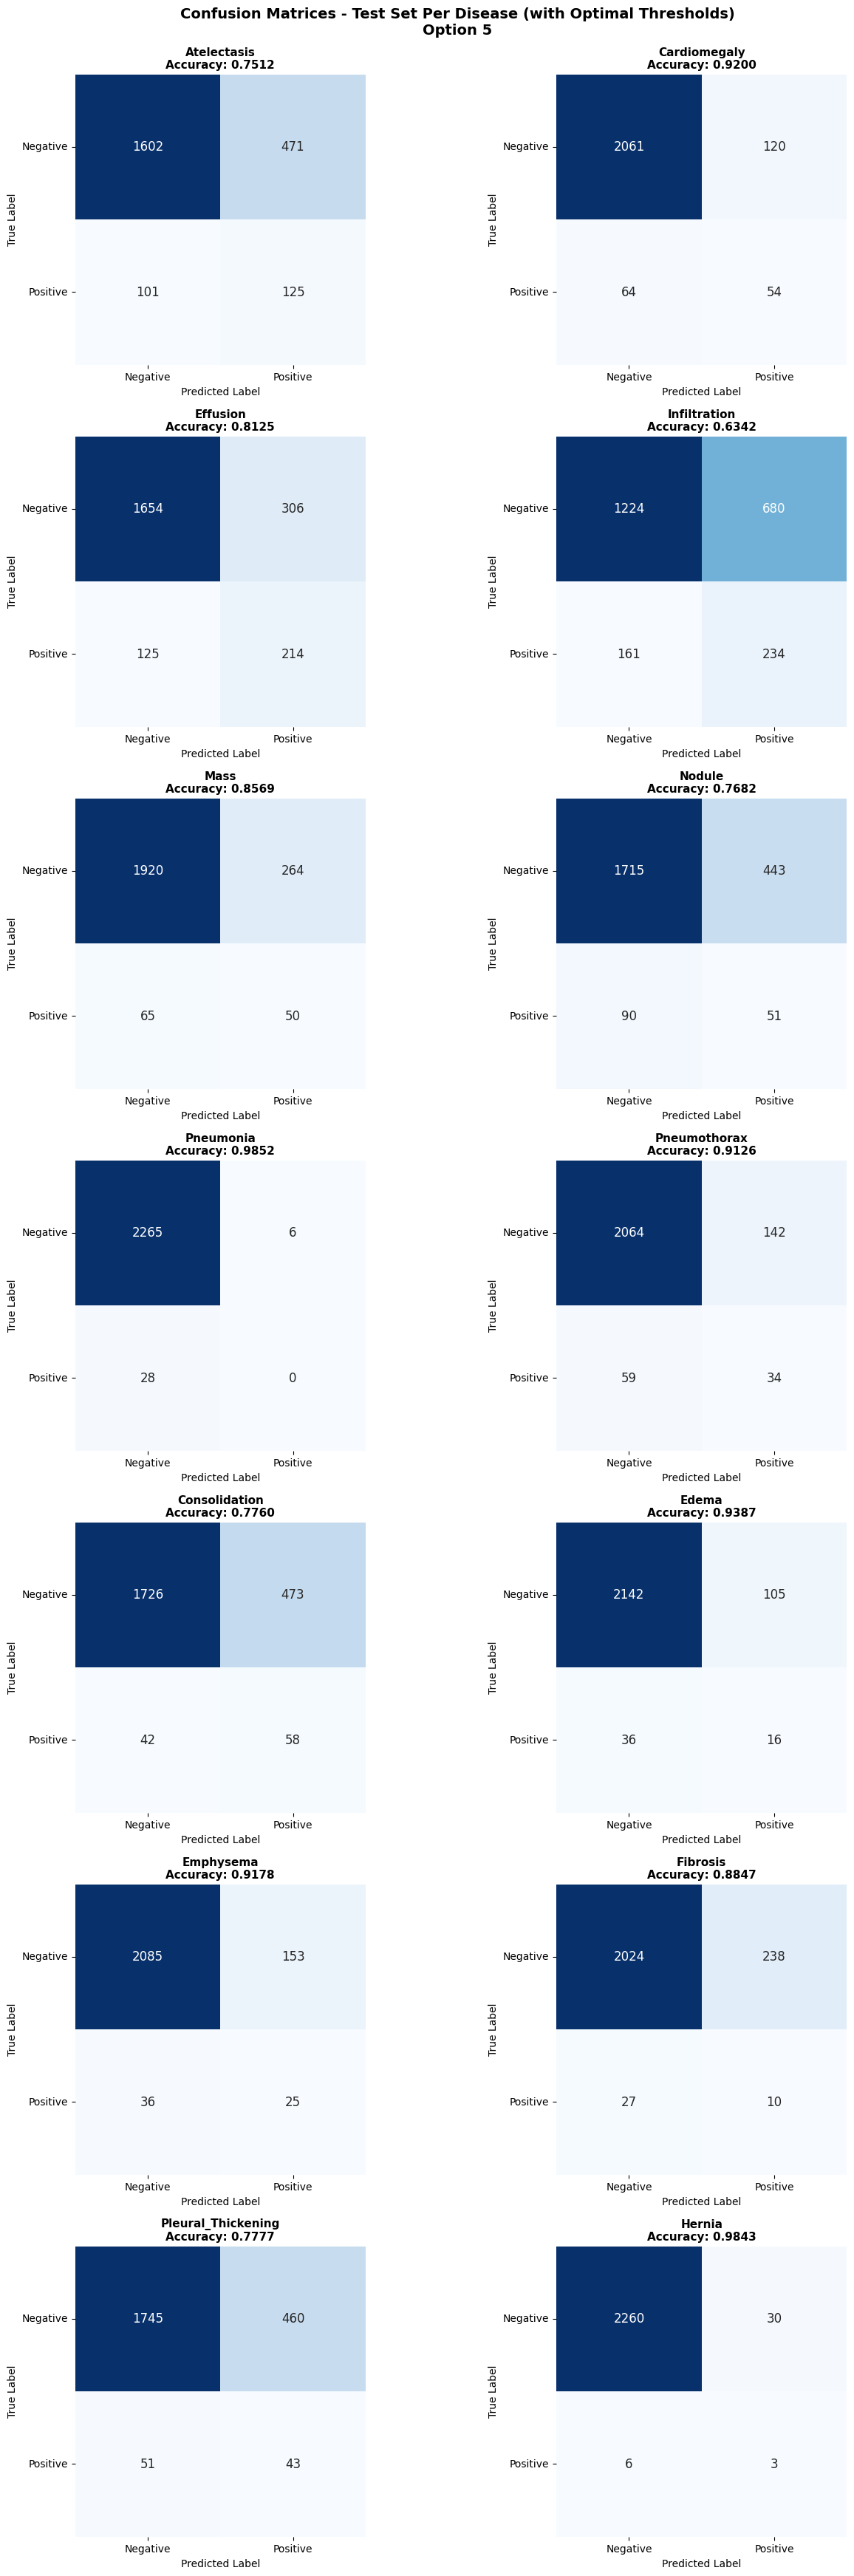

✅ Per-disease confusion matrices saved!


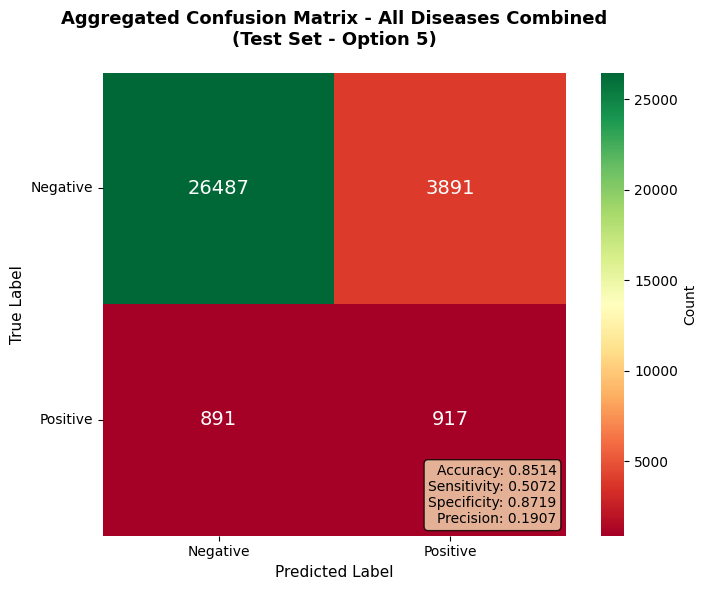

✅ Macro confusion matrix saved!

Aggregated Metrics (All Diseases Combined):
  Accuracy:    0.8514
  Sensitivity: 0.5072
  Specificity: 0.8719
  Precision:   0.1907

📋 PER-DISEASE CONFUSION MATRIX SUMMARY (Option 5)
Disease                    TN       FP       FN       TP   Accuracy  Sensitivity  Specificity
--------------------------------------------------------------------------------
Atelectasis              1602      471      101      125     0.7512       0.5531       0.7728
Cardiomegaly             2061      120       64       54     0.9200       0.4576       0.9450
Effusion                 1654      306      125      214     0.8125       0.6313       0.8439
Infiltration             1224      680      161      234     0.6342       0.5924       0.6429
Mass                     1920      264       65       50     0.8569       0.4348       0.8791
Nodule                   1715      443       90       51     0.7682       0.3617       0.7947
Pneumonia                2265        6       

In [ ]:
# ============================================
# 🎨 Step 17: Confusion Matrices Visualization (Clean)
# ============================================

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Use optimal thresholds to create binary predictions
test_preds_binary = np.zeros_like(test_preds)
for i, disease in enumerate(DISEASE_CATEGORIES):
    thresh = optimal_thresholds.get(disease, 0.5)
    test_preds_binary[:, i] = (test_preds[:, i] > thresh).astype(int)

# ============================================
# 📊 Individual Confusion Matrices Per Disease
# ============================================

# Create a grid of confusion matrices (2 columns, 7 rows for 14 diseases)
n_diseases = len(DISEASE_CATEGORIES)
n_cols = 2
n_rows = (n_diseases + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5*n_rows))
axes = axes.flatten()  # Flatten to 1D for easier indexing

for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(test_targets[:, i])) > 1:
        # Calculate confusion matrix
        cm = confusion_matrix(test_targets[:, i], test_preds_binary[:, i])
        
        # Plot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], 
                   cbar=False, annot_kws={'size': 12}, square=True)
        
        # Calculate accuracy for this disease
        accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
        
        axes[i].set_title(f'{disease}\nAccuracy: {accuracy:.4f}', fontweight='bold', fontsize=11)
        axes[i].set_ylabel('True Label', fontsize=10)
        axes[i].set_xlabel('Predicted Label', fontsize=10)
        axes[i].set_xticklabels(['Negative', 'Positive'])
        axes[i].set_yticklabels(['Negative', 'Positive'], rotation=0)
    else:
        axes[i].text(0.5, 0.5, f'{disease}\n(Insufficient data)', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Confusion Matrices - Test Set Per Disease (with Optimal Thresholds)\nOption 5', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'{OPTION_NAME}_confusion_matrices_per_disease.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Per-disease confusion matrices saved!")

# ============================================
# 📈 Macro Confusion Matrix (Aggregated)
# ============================================

# Aggregate across all diseases
cm_macro = confusion_matrix(test_targets.flatten(), test_preds_binary.flatten())

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_macro, annot=True, fmt='d', cmap='RdYlGn', ax=ax, 
           cbar_kws={'label': 'Count'}, annot_kws={'size': 14}, square=True)

ax.set_title('Aggregated Confusion Matrix - All Diseases Combined\n(Test Set - Option 5)', 
            fontsize=13, fontweight='bold', pad=20)
ax.set_ylabel('True Label', fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['Negative', 'Positive'], rotation=0)

# Add metrics annotations
tn, fp, fn, tp = cm_macro.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0

metrics_text = f'Accuracy: {accuracy:.4f}\nSensitivity: {sensitivity:.4f}\nSpecificity: {specificity:.4f}\nPrecision: {precision:.4f}'
ax.text(0.98, 0.02, metrics_text, transform=ax.transAxes, fontsize=10,
       verticalalignment='bottom', horizontalalignment='right',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig(f'{OPTION_NAME}_confusion_matrix_macro.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Macro confusion matrix saved!")
print(f"\nAggregated Metrics (All Diseases Combined):")
print(f"  Accuracy:    {accuracy:.4f}")
print(f"  Sensitivity: {sensitivity:.4f}")
print(f"  Specificity: {specificity:.4f}")
print(f"  Precision:   {precision:.4f}")

# ============================================
# 📋 Detailed Confusion Matrix Table
# ============================================

print("\n" + "="*80)
print("📋 PER-DISEASE CONFUSION MATRIX SUMMARY (Option 5)")
print("="*80)
print(f"{'Disease':20s} {'TN':>8s} {'FP':>8s} {'FN':>8s} {'TP':>8s} {'Accuracy':>10s} {'Sensitivity':>12s} {'Specificity':>12s}")
print("-"*80)

for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(test_targets[:, i])) > 1:
        cm = confusion_matrix(test_targets[:, i], test_preds_binary[:, i])
        tn, fp, fn, tp = cm.ravel()
        
        acc = (tp + tn) / (tp + tn + fp + fn)
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        print(f"{disease:20s} {tn:8d} {fp:8d} {fn:8d} {tp:8d} {acc:10.4f} {sens:12.4f} {spec:12.4f}")

print("="*80)